In [159]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.colors 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from matplotlib.colors import ListedColormap

<h3>兩群資料</h3>

In [193]:
def two(D,D_trian,D_test,lx1,lx2,ax1,ax2,ay1,ay2,k1,k2):
#----------------------------------------------------------
    fig = plt.figure(figsize=[10,12])
    axs = fig.subplots(3, 2)
#----------------------------------------     
    # 3. Estimate the coefficients (配合下面程式碼)
    n = len(D_trian[:, 0])
    X = D_trian[:,0:2]
    y = D_trian[:,2]

    # Linear Regression by sklearn
    Mdl = LinearRegression()# 建立新的 linear regression model
    Mdl.fit(X, y) # 進行估計 （ 配適 ）
    # # R2 = Mdl.score(X, y) # R−square
    intrcp = Mdl.intercept_ # 估計結果 ：beta0
    coeffs = Mdl.coef_ # # 估計結果 ：beta1, beta2, ...
    #print(intrcp)
    #print(coeffs)

    # Draw a regression line
    x = np.array([lx1, lx2])
    f = -(intrcp - 0.5 + coeffs[0] * x) / coeffs[1]
    axs[0,0].plot(x, f, lw=1,color='black')
    axs[0,0].set_title('The boundary line for Linear Regression')

    # # Calculate trianing error
    y_hat = Mdl.predict(X) # 預 測 或 計 算 擬 合 值
    y_pre = [1 if i > 0.5 else 0 for i in y_hat] # 群組判讀
    # plt.title(”Accuracy in training is {:.2f}”.format( \
    # 100 * np.mean(y_pre == y)))
    print("accuracy in training for linear regression: \
        {:.4f}%".format(100 * np.mean(y_pre == y)))
    # plt.xlabel(”$X_1$”), plt.ylabel(”$X_2$”)

    # # Calculate testing error
    X_test = D_test[:,0:2]
    y_test = D_test[:,2]
    y_hat = Mdl.predict(X_test) # 預 測 或 計 算 擬 合 值
    y_pre = [1 if i > 0.5 else 0 for i in y_hat] # 群組判讀
    print("accuracy in testing for linear regression: \
        {:.4f}%".format(100 * np.mean(y_pre == y_test)))
    print("------------------------------------------")
#------------------------------------------

    # Augmented regression line by a contour line at 0.5
    x1 = D_trian[:, 0:1] # n x 1 vector
    x2 = D_trian[:, 1:2]
    X = np.hstack((x1, x2, x1 * x2, x1 ** 2, x2 ** 2))
    y = D_trian[:,2]
    n = len(y)

    # Augmented Regression Model by sklearn
    Mdl = LinearRegression()# 建立新的 linear regression model
    Mdl.fit(X, y) # 進行估計 （ 配適 ）
    # R2 = Mdl.score(X, y) # R−square
    intrcp = Mdl.intercept_ # 估計結果 ：beta0
    coeffs = Mdl.coef_ # # 估計結果 ：beta1, beta2, ...
    #print(intrcp)
    #print(coeffs)

    # # Calculate trianing error
    y_hat = Mdl.predict(X) # 預 測 或 計 算 擬 合 值
    y_pre = [1 if i > 0.5 else 0 for i in y_hat] # 群組判讀
    print("accuracy in training for augmented regression: \
        {:.4f}%".format(100 * np.mean(y_pre == y)))

    # # Calculate testing error
    x1 = D_test[:, 0:1] # n x 1 vector
    x2 = D_test[:, 1:2]
    X = np.hstack((x1, x2, x1 * x2, x1 ** 2, x2 ** 2))
    y = D_test[:,2]
    n = len(y)

    y_hat = Mdl.predict(X) # 預 測 或 計 算 擬 合 值
    y_pre = [1 if i > 0.5 else 0 for i in y_hat] # 群組判讀
    print("accuracy in testing for augmented regression: \
        {:.4f}%".format(100 * np.mean(y_pre == y)))
    print("------------------------------------------")
        
    #------Draw count plot---------------------------
    f = (
    lambda x: intrcp
    + coeffs[0] * x[0]
    + coeffs[1] * x[1]
    + coeffs[2] * x[0] * x[1]
    + coeffs[3] * x[0] ** 2
    + coeffs[4] * x[1] ** 2)
    xx = np.linspace(ax1,ax2, 100)
    yy = np.linspace(ay1, ay2, 100)
    X, Y = np.meshgrid(xx, yy)
    Z = f([X, Y])
    contours = axs[0,1].contour(
    X, Y, Z, levels = [0.5], colors='black', linestyles='--')
    axs[0,1].set_title('The boundary line for Augmented Regression')
        
    # ----------LDA Estimatr the group parameters------------
    X = D[:, 0:2]
    y = D[:,2]
    C1, C2 = X[y==0,:], X[y==1,:]
    for i in range (3):
        for j in range (2):
            axs[i,j].plot(C1[:,0], C1[:,1], 'r.', label = 'Group A')
            axs[i,j].plot(C2[:,0], C2[:,1],'b.', label = 'Group B')
            axs[i,j].legend()
    #---------------------------------------        
    n = D[:,0].size
    n1, n2 = C1[:,0].size, C2[:,0].size
    pi1, pi2 = n1/n, n2/n
    mu1, mu2 = np.mean(C1, axis = 0), np.mean(C2, axis = 0)
    Sigma = (np.cov(C1.T) + np.cov(C2.T))/2

    #------LDA直線函數估計與繪圖-----------
    K = np.log(pi1/pi2) - 0.5 * (mu1 + mu2) \
    @ LA.inv(Sigma) @ (mu1 - mu2).T
    L = LA.inv(Sigma) @ (mu1 - mu2).T
    f = lambda x : -L[0]/L[1] * x - K/L[1]
    x = np.linspace(lx1, lx2, 50)
    axs[1,0].plot(x, f(x),'k')
    axs[1,0].set_title('The boundary line for LDA')
    #--------------錯判率--------------
    Lda = LinearDiscriminantAnalysis(tol = 1e-6)
    Lda.fit(X, y)
    K = Lda.intercept_
    L = Lda.coef_
    MissClassRateLDA_2=  Lda.score(X, y)
    print('Training error for LDA={:.4f}'.format(MissClassRateLDA_2))
    MissClassRateLDA_2=  Lda.score(D_test[:,0:2],D_test[:,2])
    print('Testing error for LDA={:.4f}'.format(MissClassRateLDA_2))
    print("------------------------------------------")

    #------QDA
    Qda = QuadraticDiscriminantAnalysis(\
    tol = 1e-6, store_covariance = True)
    Qda.fit(X, y)
    nx, ny = 100, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    x_ = np.linspace(x_min, x_max, nx)
    y_ = np.linspace(y_min, y_max, ny)
    xx, yy = np.meshgrid(x_, y_)
    Z = Qda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    contoursQDA = axs[1,1].contour(xx, yy, Z, [0.5],colors = 'k',linestyles='--')
    axs[1,1].set_title('The boundary line for QDA')
    MissClassRateQDA_2=  Qda.score(X,y)
    print('Training error for QDA={:.4f}'.format(MissClassRateQDA_2))
    MissClassRateQDA_2= Qda.score(D_test[:,0:2],D_test[:,2])
    print('Testing error for QDA={:.4f}'.format(MissClassRateQDA_2))
    print("------------------------------------------")

    #----KNN
    K = k1
    weights = 'uniform'
    Knn = KNeighborsClassifier(K, weights = weights)
    Knn.fit(X, y)
    trainingErr = 1 - Knn.score(X, y)
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),\
    np.arange(y_min, y_max, 0.1))
    z = Knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = z.reshape(xx.shape)
    cmap_light = matplotlib.colors .ListedColormap(['red','cornflowerblue' ])
    axs[2,0].contourf(xx, yy, Z, cmap = cmap_light, alpha = 0.3)
    axs[2,0].set_title('The boundary line for KNN,K=%d'%K)
    trainingErr=  Knn.score(X,y)
    print('Training error = %.4f for K = %i' % (trainingErr,K))
    testingErr= Knn.score(D_test[:,0:2],D_test[:,2])
    print('Testing error = %.4f for K = %i' % (testingErr,K))
    print("------------------------------------------")
    K = k2
    weights = 'uniform'
    Knn = KNeighborsClassifier(K, weights = weights)
    Knn.fit(X, y)
    trainingErr = 1 - Knn.score(X, y)
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),\
    np.arange(y_min, y_max, 0.1))
    z = Knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = z.reshape(xx.shape)
    cmap_light = matplotlib.colors .ListedColormap(['red','cornflowerblue' ])
    axs[2,1].contourf(xx, yy, Z, cmap = cmap_light, alpha = 0.3)
    axs[2,1].set_title('The boundary line for KNN,K=%d'%K)
    trainingErr=  Knn.score(X,y)
    print('Training error = %.4f for K = %i' % (trainingErr,K))
    testingErr= Knn.score(D_test[:,0:2],D_test[:,2])
    print('Testing error = %.4f for K = %i' % (testingErr,K))
    fig.tight_layout()


In [221]:
#資料
n1, n2 = 200, 200
m1, m2 = np.array([0, 1]), np.array([0, 0])
Cov1 = np.array([[1, -0.9], [-0.9, 1]])
Cov2 = np.array([[1, 0.9], [0.9, 1]])
mvn1 = multivariate_normal(mean = m1, cov = Cov1)
mvn2 = multivariate_normal(mean = m2, cov = Cov2)
A, B = mvn1.rvs(n1), mvn2.rvs(n2)
X = np.vstack((A, B))
y = np.hstack((np.zeros(n1), np.ones(n2)))
np.savetxt("HW7_2data_4.txt", np.c_[X, y],\
fmt = "%.4f %.4f %d", header = "X1 X2 y")

accuracy in training for linear regression:         72.5000%
accuracy in testing for linear regression:         70.0000%
------------------------------------------
accuracy in training for augmented regression:         84.6875%
accuracy in testing for augmented regression:         85.0000%
------------------------------------------
Training error for LDA=0.7250
Testing error for LDA=0.7125
------------------------------------------
Training error for QDA=0.8850
Testing error for QDA=0.8875
------------------------------------------
Training error = 0.8850 for K = 15
Testing error = 0.8375 for K = 15
------------------------------------------
Training error = 0.8925 for K = 5
Testing error = 0.8500 for K = 5


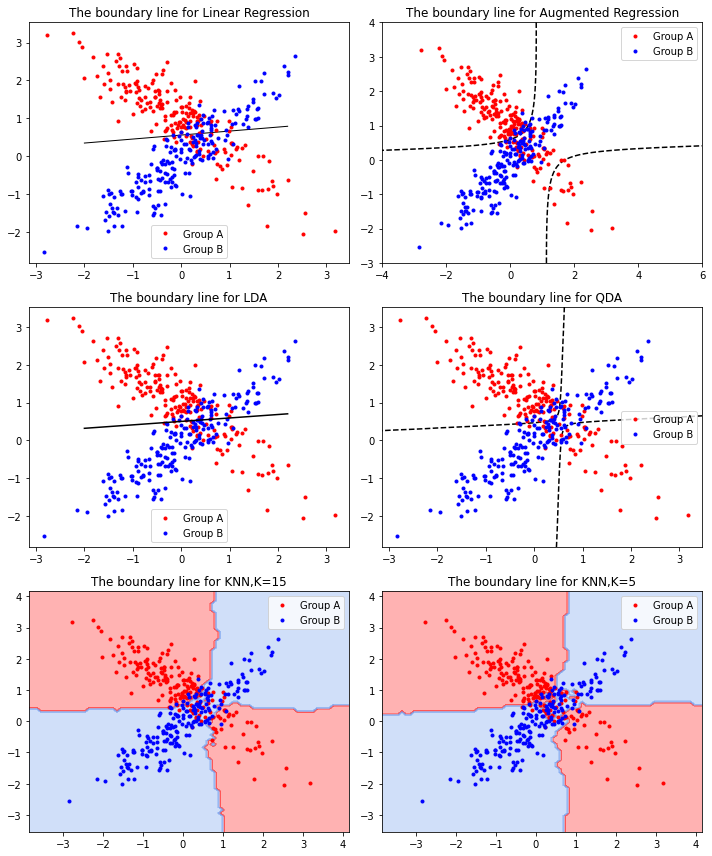

In [445]:
D = np.loadtxt('E:/統計應用/HW7_2data_4.txt')
D_trian,D_test= train_test_split(D,test_size=0.2,train_size=0.8)
lx1,lx2,ax1,ax2,ay1,ay2=-2,2.2,-4,6,-3,4
k1=15
k2=5
two(D,D_trian,D_test,lx1,lx2,ax1,ax2,ay1,ay2,k1,k2)
#G:\碩班\統計與數學應用\HW7圖片

In [436]:
def two_ann(D,D_train,D_test,X,y,h):
    hidden_layers = (h)
    solver = 'lbfgs' # the best for robot data
    clf = MLPClassifier(max_iter = 8000, solver = solver,hidden_layer_sizes = hidden_layers, verbose = False
,activation = 'logistic', # default activation = 'relu' 
    tol=1e-6, random_state = 0)
    clf.fit(D_train[:,0:2],D_train[:,2]) # Training ...
    OutputY_hat = clf.predict(D_test[:,0:2]) # Calculate fitted values
    print("accuracy by score for trained data: {:.2f}%".format(100*clf.score(D_train[:,0:2],D_train[:,2])))
    print("accuracy by score for tested data: {:.2f}%".format(100*clf.score(D_test[:,0:2],D_test[:,2])))



In [449]:
two_ann(D,D_trian,D_test,X,y,20)
print("--------------------------")
two_ann(D,D_trian,D_test,X,y,10)

accuracy by score for trained data: 96.88%
accuracy by score for tested data: 78.75%
--------------------------
accuracy by score for trained data: 90.94%
accuracy by score for tested data: 83.75%


<h3>三群資料</h3>

In [458]:
#LDA------------
def lda(D,D_train,D_test,X,y,axs):
    #_, ax = plt.subplots(figsize=(6, 4))
    Lda = LinearDiscriminantAnalysis(tol = 1e-6)
    Lda.fit(X, y)
    #D_trian,D_test= train_test_split(D,test_size=0.2,train_size=0.8)
    MissClassRateLDA_2=  Lda.score(X, y)
    print('Training error for LDA={:.4f}'.format(MissClassRateLDA_2))
    MissClassRateLDA_2=  Lda.score(D_test[:,0:2],D_test[:,2])
    print('Testing error for LDA={:.4f}'.format(MissClassRateLDA_2))

    nx, ny = 200, 100
    x_min, x_max = axs.set_xlim()
    y_min, y_max = axs.set_ylim()
    x_ = np.linspace(x_min, x_max, nx)
    y_ = np.linspace(y_min, y_max, ny)
    xx, yy = np.meshgrid(x_, y_)
    x1, x2 = xx.ravel(), yy.ravel()
    zz = Lda.predict(np.c_[x1, x2])

    colors =['#F2CBCB', '#CBEFF2','#B4EEB4']
    for i in range(3) :
        axs.scatter(x1[zz==i], x2[zz==i], marker='.',
        color=colors[i])

    axs.grid(True)
    axs.set_title('The pseudo colors for LDA')
    #axs.show()
#QDA------------
def qda(D,D_train,D_test,X,y,axs):
    #D_trian,D_test= train_test_split(D,test_size=0.2,train_size=0.8)
    Qda = QuadraticDiscriminantAnalysis(tol = 1e-6, store_covariance = True)
    Qda.fit(X,y)
    MissClassRateQDA_2=  Qda.score(X,y)
    print('Training error for QDA={:.4f}'.format(MissClassRateQDA_2))
    MissClassRateQDA_2= Qda.score(D_test[:,0:2],D_test[:,2])
    print('Testing error for QDA={:.4f}'.format(MissClassRateQDA_2))

    nx, ny = 200, 100
    x_min, x_max = axs.set_xlim()
    y_min, y_max = axs.set_ylim()
    x_ = np.linspace(x_min, x_max, nx)
    y_ = np.linspace(y_min, y_max, ny)
    xx, yy = np.meshgrid(x_, y_)
    x1, x2 = xx.ravel(), yy.ravel()
    zz = Qda.predict(np.c_[x1, x2])

    colors =['#F2CBCB', '#CBEFF2','#B4EEB4']
    for i in range(3) :
        axs.scatter(x1[zz==i], x2[zz==i], marker='.',
        color=colors[i])

    axs.grid(True)
    axs.set_title('The pseudo colors for QDA')
    #axs.show()
def knn(D,D_train,D_test,y,X,k,axs):
    n = len(y)
    y = D[:,2].astype('int') # convert to integers
    
    # ------KNN learning-------
    K = k
    intrvl = 0.2 # grid interval
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, intrvl), \
    np.arange(y_min, y_max, 0.1)) # grid points: matrices
    z = np.zeros(xx.size) # a vector for KNN predictions
    weights = 'uniform'
    Knn = KNeighborsClassifier(K, weights = weights)
    Knn.fit(X, y)
    trainingErr =  Knn.score(X, y)
    z = Knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = z.reshape(xx.shape)
    cmap_light = matplotlib.colors .ListedColormap(['red', 'blue','green'])
    axs.contourf(xx, yy, Z, cmap = cmap_light, alpha = 0.3)
    print(('Training error = %.4f for K = %i' % (trainingErr,K)))
    testingErr =  Knn.score(D_test[:,0:2],D_test[:,2])
    print('Testing error = %.4f for K = %i' % (testingErr,K))
    axs.set_title('The pseudo colors and boundary line for KNN,K=%d'%K)
    #plt.show()
    
def log(D,D_train,D_test,X,y,axs):
    # Create an instance of Logistic Regression Classifier and fit the data.
    logreg = LogisticRegression(C=1e5)
    logreg.fit(X, y)
    
    trainingAcc =  logreg.score(X, y)
    testingAcc =  logreg.score(D_test[:,0:2],D_test[:,2])
    print('Training acc = %.4f for logistic' % trainingAcc)
    print('Testing acc = %.4f for logistic' % testingAcc)

    cmap_light = matplotlib.colors .ListedColormap(['lightcoral', 'lightskyblue','limegreen'])
    DecisionBoundaryDisplay.from_estimator(
        logreg,
        X,
        cmap=cmap_light,
        alpha = 0.3,
        ax=axs,
        response_method="predict",
        eps=0.5,
    )
    # Plot also the training points
    axs.grid(True)
    axs.set_title('The pseudo colors for Logistic')

def ann(D,D_train,D_test,X,y,axs,h):
    hidden_layers = (h)
    solver = 'lbfgs' # the best for robot data
    clf = MLPClassifier(max_iter = 10000, solver = solver,hidden_layer_sizes = hidden_layers, verbose = False
,activation = 'logistic', # default activation = 'relu' 
    tol=1e-6, random_state = 0)
    clf.fit(X,y) # Training ...
    OutputY_hat = clf.predict(D_test[:,0:2]) # Calculate fitted values
    print("accuracy by score for trained data: {:.2f}%".format(100*clf.score(X,y)))
    print("accuracy by score for tested data: {:.2f}%".format(100*clf.score(D_test[:,0:2],D_test[:,2])))

In [468]:
#資料
n1,n2,n3 = 200,100,100
n = [200,100,100]
mu1,mu2,mu3 = np.array([-1, 2]), np.array([0, 0]),np.array([1, 0])
cov1 = np.array([[1, 0.5], [0.3, 1]])
cov2 = np.array([[0.6, -0.9], [-0.5, 0.9]]) 
cov3 = np.array([[0.8, 0.5], [0.3, 0.6]])
rng=np.random.default_rng(123)
mvn1 = multivariate_normal(mean = mu1, cov = cov1)
mvn2 = multivariate_normal(mean = mu2, cov = cov2)
mvn3 = multivariate_normal(mean = mu3, cov = cov3)
A,B,C=mvn1.rvs(n1,random_state=rng),mvn2.rvs(n2,random_state=rng),mvn3.rvs(n3,random_state=rng)
X = np.vstack((A, B ,C)) #疊起來
twos=np.zeros(n3)
for i in range(100):
    twos[i] = 2
y = np.hstack((np.zeros(n1),np.ones(n2),twos))
np.savetxt('HW7_3data_4.txt', np.c_[X, y],fmt = "%.4f %.4f %d")



Training error for LDA=0.7475
Testing error for LDA=0.7625
------------------------
Training error for QDA=0.8600
Testing error for QDA=0.9125
------------------------
Training error = 0.8725 for K = 5
Testing error = 0.9250 for K = 5
------------------------
Training error = 0.8425 for K = 15
Testing error = 0.8875 for K = 15
------------------------
Training acc = 0.7400 for logistic
Testing acc = 0.7625 for logistic
------------------------
accuracy by score for trained data: 93.75%
accuracy by score for tested data: 93.75%
------------------------
accuracy by score for trained data: 91.50%
accuracy by score for tested data: 91.25%


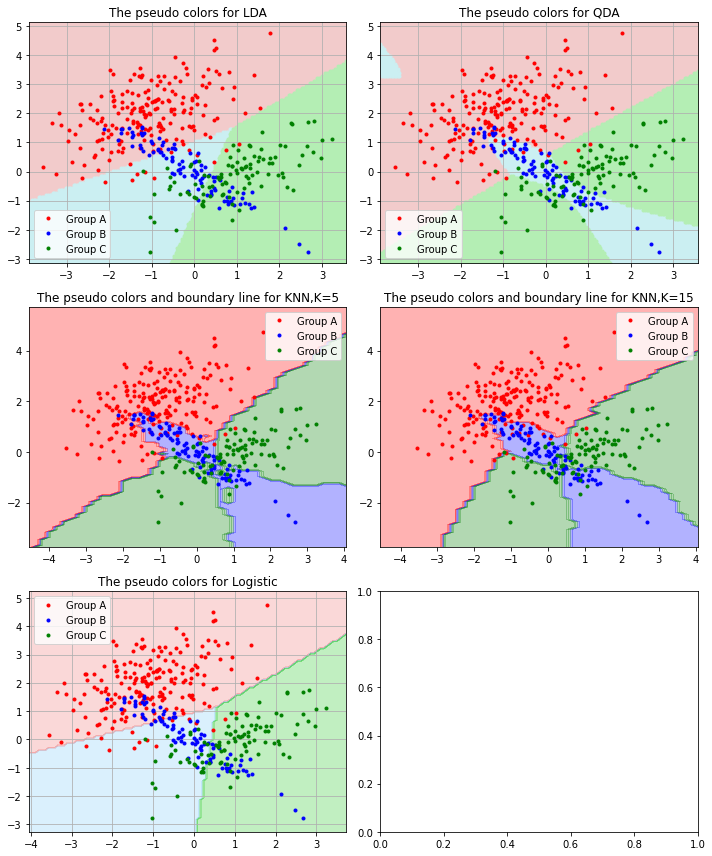

In [473]:
data_dir = 'E:/統計應用/'
D = np.loadtxt(data_dir + 'HW7_3data_4.txt', comments='%')
D_train,D_test= train_test_split(D,test_size=0.2,train_size=0.8)
fig = plt.figure(figsize=[10,12])
axs = fig.subplots(3, 2)
C1, C2,C3 = X[y==0,:], X[y==1,:],X[y==2,:]
for i in range (3):
        for j in range (2):
            if((i,j)!=(2,1)):
                axs[i,j].plot(C1[:,0], C1[:,1], 'r.', label = 'Group A')
                axs[i,j].plot(C2[:,0], C2[:,1],'b.', label = 'Group B')
                axs[i,j].plot(C3[:,0], C3[:,1],'g.', label = 'Group C')
                axs[i,j].legend()

lda(D,D_train,D_test,X,y,axs[0,0])
print("------------------------")
qda(D,D_train,D_test,X,y,axs[0,1])
print("------------------------")
knn(D,D_train,D_test,y,X,5,axs[1,0])
print("------------------------")
#'''
knn(D,D_train,D_test,y,X,15,axs[1,1])
print("------------------------")
log (D,D_train,D_test,X,y,axs[2,0])
print("------------------------")
ann(D,D_train,D_test,X,y,axs,20)
print("------------------------")
ann(D,D_train,D_test,X,y,axs,10)
#'''
fig.tight_layout()
plt.show()